<a href="https://colab.research.google.com/github/zinabu-dot/COVID-19-Modeling_AA/blob/master/Zinabu_Melese.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Assignment for Stock prediction**
---
* The business problem appears to focus on making an **investment** on McDonald’s stock (MCD) if at least **10% profit** is about to earn in the next 10 working days following the purchase day. 

* Considering the nature of the challenge (as already stated in the assignment document), the assignment is a **classification (binary)** problem. 

* The dataset for this challenge are based on [Raboresearch_label_data](https://docs.google.com/uc?export=download&id=1cp5YFvszZuFw3IusD6EWKfL8AeCSf9Lg) and [Raboresearch_feature_data](https://docs.google.com/uc?export=download&id=1BawB1Zm43rmk7HMftFWnwizN-cyd7nnD) and can be accessed using the following commands.

In [5]:
!wget -O label_raw.csv 'https://docs.google.com/uc?export=download&id=1cp5YFvszZuFw3IusD6EWKfL8AeCSf9Lg' -q --show-progress
!wget -O features.zip 'https://docs.google.com/uc?export=download&id=1BawB1Zm43rmk7HMftFWnwizN-cyd7nnD' -q --show-progress 
!unzip features.zip 
!ls

label_raw.csv       100%[===================>] 937.80K  --.-KB/s    in 0.008s  
features.zip        100%[===================>]   2.03M  --.-KB/s    in 0.01s   
Archive:  features.zip
  inflating: features.xlsx           
features.xlsx  features.zip  label_raw.csv  sample_data


---
## **Import** libraries
---

In [50]:
pip install tensorflow-addons

     |████████████████████████████████| 1.1 MB 8.1 MB/s 


In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline 

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

import tensorflow as tf
from tensorflow import keras
from tensorflow_addons import losses

---
# Reading the label data
---

In [63]:
# reading the label data
df_lab = pd.read_csv('label_raw.csv')

# checking the datatype of each column
df_lab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13728 entries, 0 to 13727
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          13728 non-null  object 
 1   Open          13728 non-null  float64
 2   High          13728 non-null  float64
 3   Low           13728 non-null  float64
 4   Close         13728 non-null  float64
 5   Volume        13728 non-null  int64  
 6   Dividends     13728 non-null  float64
 7   Stock Splits  13728 non-null  float64
dtypes: float64(6), int64(1), object(1)
memory usage: 858.1+ KB


In [64]:
df_lab.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,7/5/1966,0.0,0.004074,0.003982,0.004013,388800,0.0,0.0
1,7/6/1966,0.0,0.004227,0.003982,0.004227,687200,0.0,0.0
2,7/7/1966,0.0,0.004335,0.004044,0.004074,1853600,0.0,0.0
3,7/8/1966,0.0,0.004120,0.003982,0.004120,1238400,0.0,0.0
4,7/11/1966,0.0,0.004227,0.004059,0.004105,655200,0.0,0.0


From the above output, it can be seen that the **'Date'** column is a **string type**. It has to be converted into **datetime object**.

In [65]:
def to_datetime():
  # convert the string date to datetime format
  df_lab['Date'] = pd.to_datetime(df_lab['Date'])

  # get the names of the week days
  df_lab['weekday_name'] = df_lab['Date'].dt.day_name()

  # filtering on working days 
  df_lab_wd = df_lab[(df_lab['weekday_name']!='Saturday') | (df_lab['weekday_name']!='Sunday')]

  # As the sale is made on weekdays 
  return df_lab_wd

# let's give the same name for the data obtained from the function as it was named before

df_lab = to_datetime()
df_lab.shape

(13728, 9)

# **Visualize** the missing values in each column for the sake of **data qualitiy management**

Date            0.0
Open            0.0
High            0.0
Low             0.0
Close           0.0
Volume          0.0
Dividends       0.0
Stock Splits    0.0
weekday_name    0.0
dtype: float64


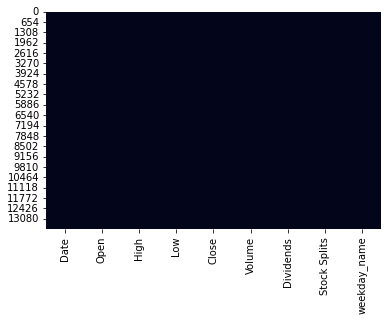

In [66]:
def missing_heatmap():
  # heatmap plot to see the position/location of missing values (if any)
  sns.heatmap(df_lab.isnull(), cbar=False)

  # print the proportion of missing values in each column
  print(df_lab.isnull().mean())
missing_heatmap()

As per the results above, the label data is _**clean in terms of missing values**_. 

# **Dichotomize the investiment as positive and negative**
---
**Positive** if $profit$ reads at **least 10% with in 10 working days** following a purchase day, **negative** otherwise.

Take the maximum of the lowest selling prices in the 10 working days immediate to purchase day: 

<center> $sell = \max{\{sell_{t+1}, ..., sell_{t+10}\}}$ <center/> 

<justify> where $t$ is the purchase day. <justify/>

then calculate the profit percentage as:

<center> $profit = \frac{sell - purchase_t}{purchase_t}\times 100$ <center/>


In [67]:
def calc_profit():
  d = 10
  df_lab['profit'] = ((pd.Series(df_lab['Low']).rolling(d)).max().shift(-d) - pd.Series(df_lab['High']))/pd.Series(df_lab['High'])
  df_lab_pro = df_lab.dropna()
  return df_lab_pro
df_lab = calc_profit()
df_lab.head()


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,weekday_name,profit
0,1966-07-05,0.0,0.004074,0.003982,0.004013,388800,0.0,0.0,Tuesday,-0.003759
1,1966-07-06,0.0,0.004227,0.003982,0.004227,687200,0.0,0.0,Wednesday,-0.039855
2,1966-07-07,0.0,0.004335,0.004044,0.004074,1853600,0.0,0.0,Thursday,-0.063604
3,1966-07-08,0.0,0.004120,0.003982,0.004120,1238400,0.0,0.0,Friday,-0.014870
4,1966-07-11,0.0,0.004227,0.004059,0.004105,655200,0.0,0.0,Monday,-0.047101


In [68]:
# Labeling the investment based on the minimum of 10% profit
def investment_label(gain):
  if gain >= 0.1:
    return 'positive'
  else:
    return 'negative'
df_lab['label'] = df_lab['profit'].map(investment_label)


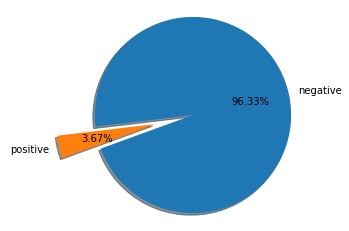

In [69]:
# Distribution of the positive and negative investments 
def label_dist():

	df_perc = pd.DataFrame(df_lab.groupby('label')['label'].count() * 100/(df_lab.groupby('label')['label'].count().sum()))\
    	.rename(columns={'label':'animal_percent'}).reset_index()


	explode = (0, 0.4)  

	fig1, ax1 = plt.subplots()
	ax1.pie(df_perc['animal_percent'], explode=explode,
	 	labels=df_perc['label'], autopct='%1.2f%%',
        	shadow=True, startangle=200)
	ax1.axis('equal')
 
if __name__ == "__main__":
  label_dist()


# Reading features data

In [70]:
df_feat = pd.ExcelFile('features.xlsx')
df_feat.sheet_names

# Reading the data in each sheets
df_featA = pd.read_excel('features.xlsx', sheet_name=None)

In [71]:
df_gdp = df_featA[df_feat.sheet_names[3]]

Text(0, 0.5, 'Close price')

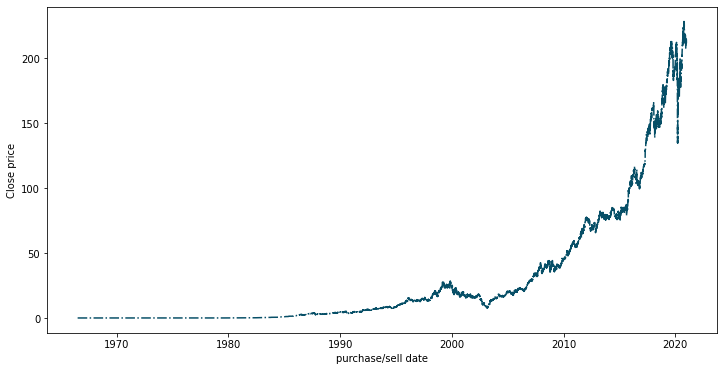

In [72]:
# Trend for Close price 
plt.figure(figsize=(12,6))
plt.plot(df_lab['Date'], df_lab['Close'], ls='-.', color='#074F67')
plt.xlabel('purchase/sell date')
plt.ylabel('Close price' )

# df_lab['Close'].plot(style='-.', xlabel='purchase/sell date',
#                      ylabel='Close price', figsize=(12,6), color='#074F67', secondary_y=True)

In [73]:
# replace the (target) text labels by numberic scores, so that the state-of-the-art method can understand them
df_lab['label'] = df_lab['label'].replace({'negative':0, 'positive':1})

In [74]:
# Considering 'Open' price and Volume as features 
# Checking the strength of the correlation between 'Open' and Volume, in order to avoid collinearity issue in 
df_lab[['Open', 'Volume']].corr()

,Open,Volume
Open,1.00000,0.11519
Volume,0.11519,1.00000


# **Scaling features' values**

---
 * Standardize values for less memory usage and precision 

In [75]:
def feat_scale():
  scaler = MinMaxScaler()
  transform = scaler.fit_transform(df_lab[['Open', 'Volume']])
  df_feat = pd.DataFrame(data=transform, columns=['Open', 'Volume'])
  return df_feat
df_feat = feat_scale()
df_feat.tail()

,Open,Volume
13713,0.926092,0.011500
13714,0.929890,0.028782
13715,0.937094,0.018609
13716,0.929759,0.020786
13717,0.922293,0.029473


In [76]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(df_feat, df_lab['label'], test_size=0.25, stratify=df_lab['label'])

## **Binary prediction**

In [77]:
nb = GaussianNB()
lr = LogisticRegression(max_iter = 2000)
dt = DecisionTreeClassifier(max_depth=5, random_state = 42)
rf = RandomForestClassifier(max_depth=5, random_state = 42)
svc = SVC(probability = True, C=1)
knn = KNeighborsClassifier(n_neighbors=7)
xgb = XGBClassifier(random_state =1)


models = [nb, lr, dt, rf,  svc, knn, xgb ] 
models_name = [
   "Naive Bayes",
   "Logistic Regression",
    "Decision Tree",
    "Random Forest",
    "SVM",
    "K-Nearest Neighbor",
    "XGBoost",
   
]

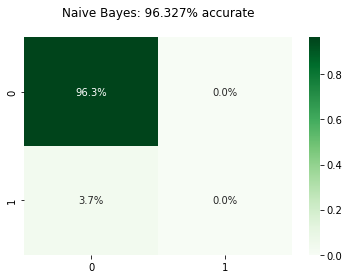

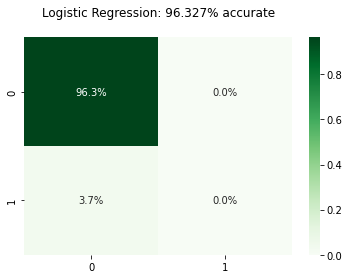

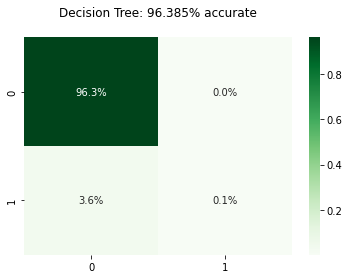

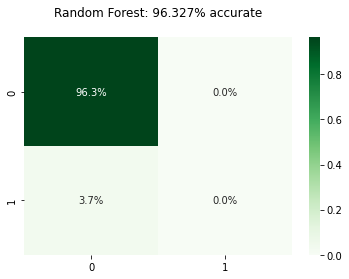

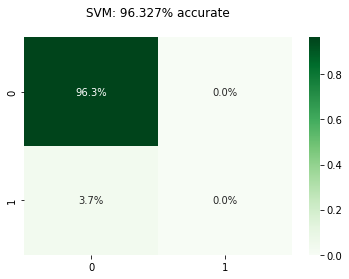

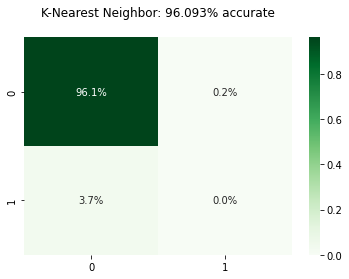

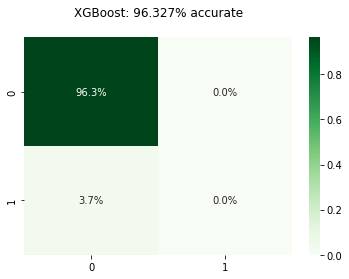

In [78]:
# results without CV
def ml_model():

  results = {}

  for index, model in enumerate(models):
      model.fit(X_train, y_train)
      predict = (model.predict(X_test) > 0.8).astype(int)
      confuse = confusion_matrix(y_test, predict)
      accur = accuracy_score(y_test, predict)
      results[models_name[index]] = accur * 100.0
      
      title = models_name[index] + ": " + "{:.3f}%".format(accur*100) + " accurate\n"
      ax = sns.heatmap(confuse/np.sum(confuse), annot=True, fmt='.1%', cmap="Greens")
      ax.set_title(title)
      plt.show()
  return results
results = ml_model()

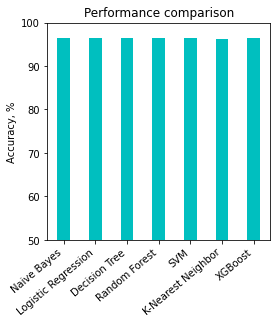

In [79]:
x = np.arange(len(results))

plt.figure(figsize=(4,4))
plt.bar(x, results.values(), width=0.4, color="c", align="center")
plt.ylim((50, 100))
plt.xticks(x, results.keys())
plt.title("Performance comparison")
plt.xticks(rotation=40, horizontalalignment="right")
plt.ylabel('Accuracy, %')
plt.show()

## **Mitigation for data imblance problem**
___
* From the above results, it looks the models are predicting the majority (negative investment) class.
* Considering down sampling of the majority (negative) and upsampling of the minority (positive) investments to the size of positive and negative investments, respectively, may settle the imbalance situation.

## **Strategy I**
___
* **Down Sample negative investments**

In [80]:
# Get the negative and positive investiments separately
df_label_0 = df_lab[df_lab.label==0]
df_label_1 = df_lab[df_lab.label==1]

In [81]:
# randomly sample down the negative investments
df_label_0_under = df_label_0.sample(len(df_label_1))
df_label_0_under.shape

(504, 11)

In [82]:
# Merge the two data frames
df_merged = pd.concat([df_label_0_under, df_label_1], axis=0)
df_merged.shape

(1008, 11)

In [83]:
df_merged.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,weekday_name,profit,label
11242,2011-03-03,56.249931,57.273876,56.182661,56.982388,7390100,0.0,0.0,Thursday,-0.008222,0
13289,2019-04-23,186.291143,187.863462,186.108981,187.201935,2192900,0.0,0.0,Tuesday,0.003981,0
5958,1990-03-16,4.365953,4.365953,4.348832,4.365953,4211600,0.0,0.0,Friday,0.011764,0
9442,2004-01-08,15.624070,15.765938,15.525379,15.728930,5282400,0.0,0.0,Thursday,-0.009390,0
6917,1993-12-30,8.237664,8.255418,8.184403,8.184403,1445600,0.0,0.0,Thursday,-0.002151,0


In [84]:
X_train, X_test, y_train, y_test = train_test_split(df_merged[['Open', 'Volume']],
                                                    df_merged['label'], test_size=0.25)

classification report for Naive Bayes 
               precision    recall  f1-score   support

           0       0.75      0.39      0.51       131
           1       0.57      0.86      0.68       121

    accuracy                           0.62       252
   macro avg       0.66      0.62      0.60       252
weighted avg       0.66      0.62      0.59       252



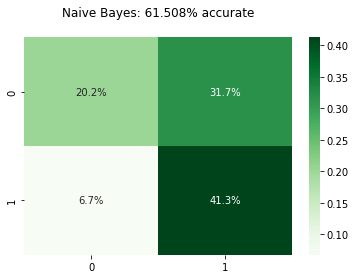

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


classification report for Logistic Regression 
               precision    recall  f1-score   support

           0       0.52      1.00      0.68       131
           1       0.00      0.00      0.00       121

    accuracy                           0.52       252
   macro avg       0.26      0.50      0.34       252
weighted avg       0.27      0.52      0.36       252



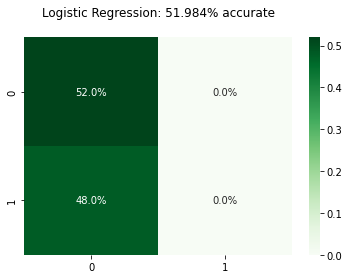

classification report for Decision Tree 
               precision    recall  f1-score   support

           0       0.79      0.71      0.75       131
           1       0.72      0.79      0.75       121

    accuracy                           0.75       252
   macro avg       0.75      0.75      0.75       252
weighted avg       0.75      0.75      0.75       252



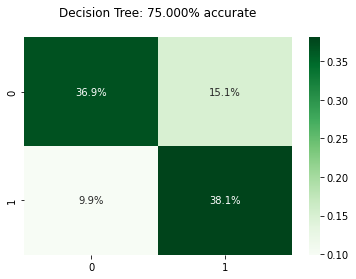

classification report for Random Forest 
               precision    recall  f1-score   support

           0       0.87      0.69      0.77       131
           1       0.72      0.89      0.80       121

    accuracy                           0.79       252
   macro avg       0.80      0.79      0.78       252
weighted avg       0.80      0.79      0.78       252



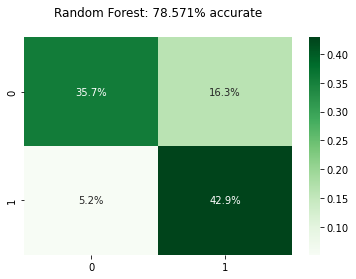

classification report for SVM 
               precision    recall  f1-score   support

           0       0.59      0.83      0.69       131
           1       0.68      0.38      0.49       121

    accuracy                           0.62       252
   macro avg       0.63      0.61      0.59       252
weighted avg       0.63      0.62      0.59       252



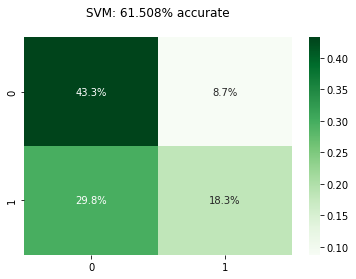

classification report for K-Nearest Neighbor 
               precision    recall  f1-score   support

           0       0.60      0.62      0.61       131
           1       0.58      0.56      0.57       121

    accuracy                           0.59       252
   macro avg       0.59      0.59      0.59       252
weighted avg       0.59      0.59      0.59       252



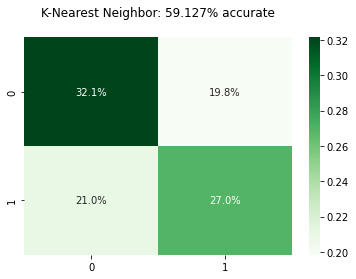

classification report for XGBoost 
               precision    recall  f1-score   support

           0       0.84      0.71      0.77       131
           1       0.73      0.85      0.79       121

    accuracy                           0.78       252
   macro avg       0.78      0.78      0.78       252
weighted avg       0.79      0.78      0.78       252



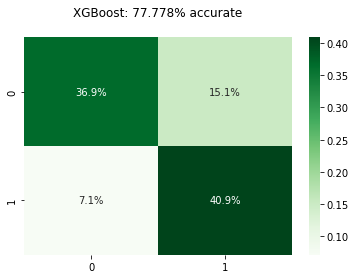

In [85]:
def ml_model_down(X_train, y_train, X_test, y_test):

  X_train, X_test, y_train, y_test = train_test_split(df_merged[['Open', 'Volume']],
                                                    df_merged['label'], test_size=0.25)
  results_down = {}

  for index, model in enumerate(models):
      model.fit(X_train, y_train)
      predict = model.predict(X_test) 
      confuse = confusion_matrix(y_test, predict)
      accur = accuracy_score(y_test, predict)
      results_down[models_name[index]] = accur * 100.0
      
      print(f'classification report for {models_name[index]} \n',classification_report(y_test, predict))
      title = models_name[index] + ": " + "{:.3f}%".format(accur*100) + " accurate\n"
      ax = sns.heatmap(confuse/np.sum(confuse), annot=True, fmt='.1%', cmap="Greens")
      ax.set_title(title)
      plt.show()
  return  results_down 

results_down = ml_model_down(X_train, y_train, X_test, y_test)

## **Strategy II**
___
* **Up (over) Sample positive investments**

In [86]:
# randomly sample down the negative investments
df_label_1_over = df_label_1.sample(len(df_label_0), replace=True)
df_label_1_over.shape

# Merge the two data frames
df_merged_ov = pd.concat([df_label_0, df_label_1_over], axis=0)
df_merged_ov.shape

(26428, 11)

classification report for Naive Bayes 
               precision    recall  f1-score   support

           0       0.68      0.32      0.44      3360
           1       0.55      0.84      0.66      3247

    accuracy                           0.58      6607
   macro avg       0.61      0.58      0.55      6607
weighted avg       0.61      0.58      0.55      6607



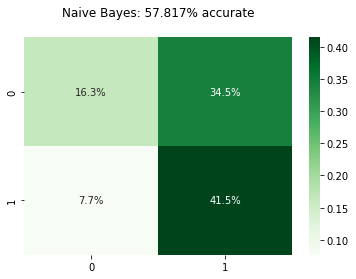

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


classification report for Logistic Regression 
               precision    recall  f1-score   support

           0       0.51      1.00      0.67      3360
           1       0.00      0.00      0.00      3247

    accuracy                           0.51      6607
   macro avg       0.25      0.50      0.34      6607
weighted avg       0.26      0.51      0.34      6607



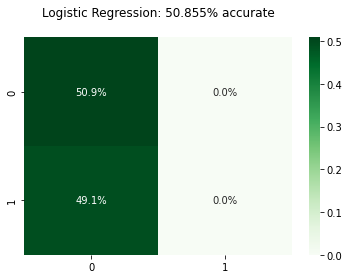

classification report for Decision Tree 
               precision    recall  f1-score   support

           0       0.80      0.76      0.78      3360
           1       0.76      0.81      0.78      3247

    accuracy                           0.78      6607
   macro avg       0.78      0.78      0.78      6607
weighted avg       0.78      0.78      0.78      6607



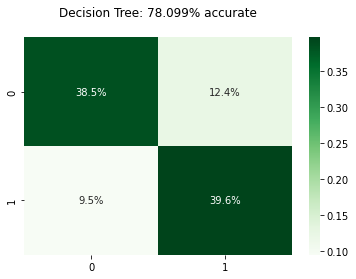

classification report for Random Forest 
               precision    recall  f1-score   support

           0       0.84      0.69      0.76      3360
           1       0.73      0.86      0.79      3247

    accuracy                           0.77      6607
   macro avg       0.78      0.78      0.77      6607
weighted avg       0.78      0.77      0.77      6607



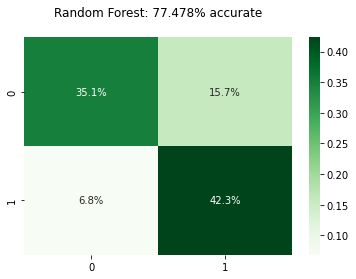

classification report for SVM 
               precision    recall  f1-score   support

           0       0.56      0.82      0.67      3360
           1       0.64      0.34      0.45      3247

    accuracy                           0.58      6607
   macro avg       0.60      0.58      0.56      6607
weighted avg       0.60      0.58      0.56      6607



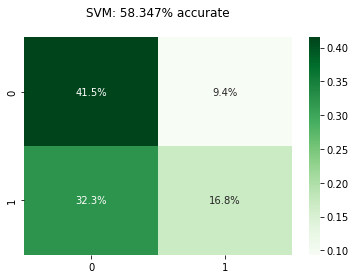

classification report for K-Nearest Neighbor 
               precision    recall  f1-score   support

           0       1.00      0.82      0.90      3360
           1       0.84      1.00      0.91      3247

    accuracy                           0.91      6607
   macro avg       0.92      0.91      0.91      6607
weighted avg       0.92      0.91      0.91      6607



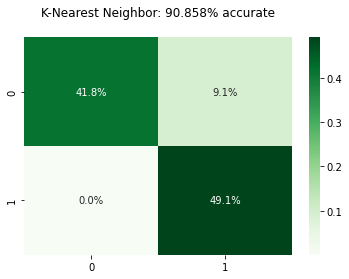

classification report for XGBoost 
               precision    recall  f1-score   support

           0       0.84      0.75      0.79      3360
           1       0.77      0.85      0.81      3247

    accuracy                           0.80      6607
   macro avg       0.80      0.80      0.80      6607
weighted avg       0.80      0.80      0.80      6607



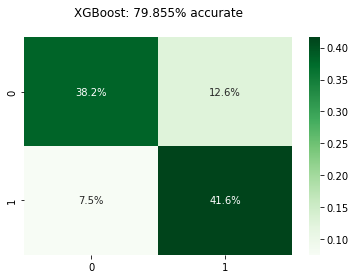

In [87]:
def ml_model_over(X_train, y_train, X_test, y_test):

  X_train, X_test, y_train, y_test = train_test_split(df_merged_ov[['Open', 'Volume']],
                                                    df_merged_ov['label'], test_size=0.25)
  results_over = {}

  for index, model in enumerate(models):
      model.fit(X_train, y_train)
      predict = model.predict(X_test) 
      confuse = confusion_matrix(y_test, predict) 
      accur = accuracy_score(y_test, predict)
      results_over[models_name[index]] = accur * 100.0
      
      print(f'classification report for {models_name[index]} \n',
            classification_report(y_test, predict))  # the term labels=np.unique(prediced) removes the warning due to zero division
      title = models_name[index] + ": " + "{:.3f}%".format(accur*100) + " accurate\n"
      ax = sns.heatmap(confuse/np.sum(confuse), annot=True, fmt='.1%', cmap="Greens")
      ax.set_title(title)
      plt.show()
  return  results_over 

results_over = ml_model_over(X_train, y_train, X_test, y_test)

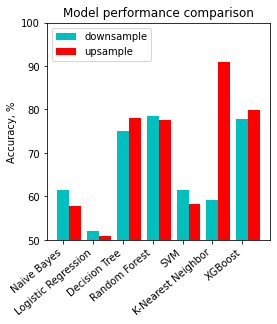

In [88]:
# x = np.arange(len(results_down))

# plt.figure(figsize=(4,4))
# plt.bar(x, results_down.values(), width=0.4, color="c", align="center")
# plt.bar(x+0.4, results_over.values(), width=0.4, color="r", align="center")
# plt.ylim((50, 100))
# plt.xticks(x, results_down.keys())
# plt.title("Performance comparison")
# plt.xticks( rotation=40, horizontalalignment="right")
# plt.ylabel('Accuracy, %')
# plt.legend(('downsample','upsample'))
# plt.show()

x = np.arange(len(results_over))

plt.figure(figsize=(4,4))
ax = plt.subplot(111)
ax.bar(x, results_down.values(), width=0.4, color="c", align="center")
ax.bar(x+0.4, results_over.values(), width=0.4, color="r", align="center")
ax.legend(("downsample", "upsample"), loc='upper left') # bbox_to_anchor=(0.8, 1)
plt.ylim((50, 100))
plt.xticks(x, results_over.keys())
plt.title("Model performance comparison")
plt.xticks( rotation=40, horizontalalignment="right")
plt.ylabel('Accuracy, %')
plt.show()

## **Deepe learning**

In [89]:
from pandas.core.algorithms import mode
def ann():

  loss = keras.losses.BinaryCrossentropy()
  weights = -1  # use the model with out weights

  model = keras.Sequential(
      [keras.layers.Dense(2, input_dim = len(X_train.columns), activation = 'relu'),
       keras.layers.Dense(2, activation = 'relu'),
       keras.layers.Dense(1, activation = 'sigmoid')]
       )
  model.compile(optimizer = 'adam', loss = loss, metrics = 'accuracy')

  if weights == -1:
    model.fit(X_train,y_train, epochs = 100)
  else:
    model.fit(X_train,y_train, epochs = 100, class_weights = weights)

  print(model.evaluate(X_test, y_test))

  y_preds = np.round(model.predict(X_test))

  print('ANN model Classification report \n', classification_report(y_test, y_preds))

  return y_preds
  

In [90]:
predicted = ann()

Epoch 1/100
24/24 [==============================] - 1s 2ms/step - loss: 150382.2188 - accuracy: 0.4974
Epoch 2/100
24/24 [==============================] - 0s 2ms/step - loss: 104481.4844 - accuracy: 0.4974
Epoch 3/100
24/24 [==============================] - 0s 2ms/step - loss: 64239.4219 - accuracy: 0.4974
Epoch 4/100
24/24 [==============================] - 0s 2ms/step - loss: 41083.1484 - accuracy: 0.4974
Epoch 5/100
24/24 [==============================] - 0s 2ms/step - loss: 22929.8574 - accuracy: 0.4974
Epoch 6/100
24/24 [==============================] - 0s 2ms/step - loss: 6541.3286 - accuracy: 0.4947
Epoch 7/100
24/24 [==============================] - 0s 2ms/step - loss: 0.6954 - accuracy: 0.5026
Epoch 8/100
24/24 [==============================] - 0s 2ms/step - loss: 0.6954 - accuracy: 0.5026
Epoch 9/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6954 - accuracy: 0.5026
Epoch 10/100
24/24 [==============================] - 0s 2ms/step - loss: 0.6953 - a

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
